In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import os

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
train_dir = '/kaggle/input/reduced/dogs-vs-cats/train'
test_dir = '/kaggle/input/reduced/dogs-vs-cats/test'

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])

In [16]:
batch_size = 4

In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
    class_names = train_data.classes

  # Turn images into data loaders
    train_dataloader = DataLoader(
          train_data,
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers,
          pin_memory=True,
      )
    test_dataloader = DataLoader(
          test_data,
          batch_size=batch_size,
          shuffle=False,
          num_workers=num_workers,
          pin_memory=True,
      )

    return train_dataloader, test_dataloader, class_names

In [18]:
import timm 
timm.list_models("swin*", pretrained=True)

['swin_base_patch4_window7_224.ms_in1k',
 'swin_base_patch4_window7_224.ms_in22k',
 'swin_base_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_base_patch4_window12_384.ms_in1k',
 'swin_base_patch4_window12_384.ms_in22k',
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_large_patch4_window7_224.ms_in22k',
 'swin_large_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_large_patch4_window12_384.ms_in22k',
 'swin_large_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_s3_base_224.ms_in1k',
 'swin_s3_small_224.ms_in1k',
 'swin_s3_tiny_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in22k',
 'swin_small_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_tiny_patch4_window7_224.ms_in1k',
 'swin_tiny_patch4_window7_224.ms_in22k',
 'swin_tiny_patch4_window7_224.ms_in22k_ft_in1k',
 'swinv2_base_window8_256.ms_in1k',
 'swinv2_base_window12_192.ms_in22k',
 'swinv2_base_window12to16_192to256.ms_in22k_ft_in1k',
 'swinv2_base_window12to24_192to384.ms_in22k_ft_in1k',


In [19]:
from timm import create_model

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir, test_dir, transform, batch_size)

model = create_model('swin_base_patch4_window7_224', pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, len(class_names))

Displaying an image from the train data loader:


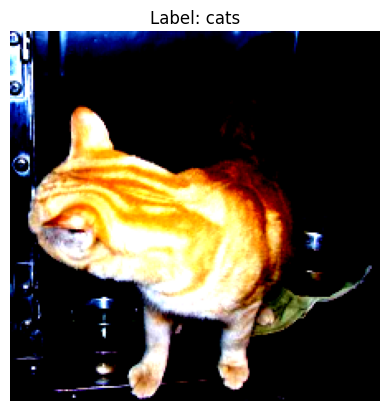

Displaying an image from the test data loader:


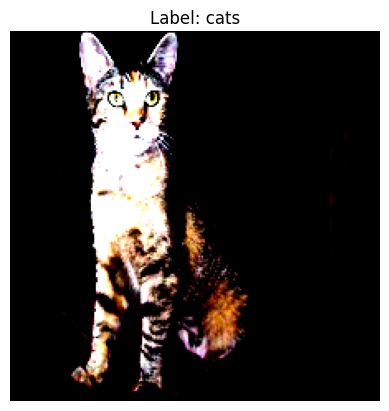

In [20]:
def show_image(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    img = np.transpose(images[0].numpy(), (1, 2, 0))
    plt.imshow(img)
    plt.title(f'Label: {class_names[labels[0]]}')
    plt.axis('off')
    plt.show()

# Display an image from the train data loader
print("Displaying an image from the train data loader:")
show_image(train_dataloader)

# Display an image from the test data loader
print("Displaying an image from the test data loader:")
show_image(test_dataloader)

In [21]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=len(class_names))
model = model.to(device)

In [22]:
# Loss and optimizer
from torch import nn, optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [23]:
num_epochs = 5
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataloader.dataset)
    train_accuracy = train_correct / len(train_dataloader.dataset)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_accuracy = test_correct / len(test_dataloader.dataset)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/5, Train Loss: 0.0274, Train Accuracy: 0.9610, Test Loss: 0.0432, Test Accuracy: 0.9520
Epoch 2/5, Train Loss: 0.0175, Train Accuracy: 0.9730, Test Loss: 0.0110, Test Accuracy: 0.9840
Epoch 3/5, Train Loss: 0.0083, Train Accuracy: 0.9860, Test Loss: 0.0098, Test Accuracy: 0.9840
Epoch 4/5, Train Loss: 0.0346, Train Accuracy: 0.9510, Test Loss: 0.0339, Test Accuracy: 0.9540
Epoch 5/5, Train Loss: 0.0144, Train Accuracy: 0.9805, Test Loss: 0.0372, Test Accuracy: 0.9440


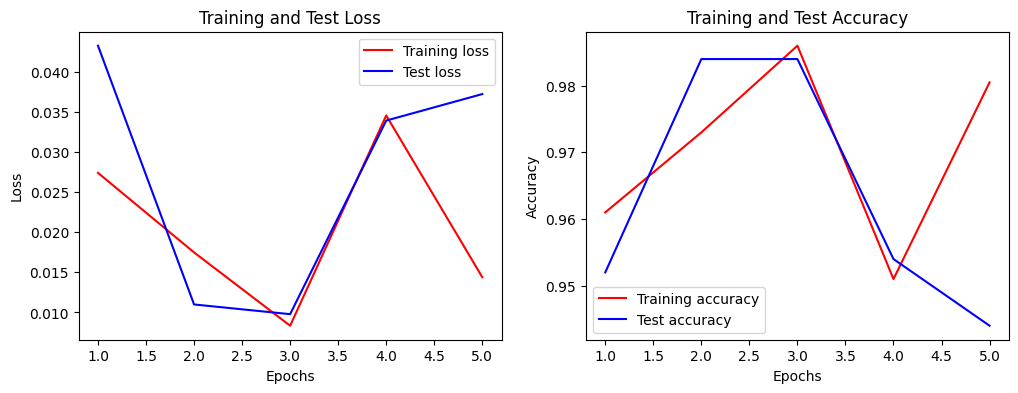

In [24]:
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'r', label='Training loss')
plt.plot(epochs, test_loss_values, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_values, 'r', label='Training accuracy')
plt.plot(epochs, test_accuracy_values, 'b', label='Test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Selected image path: /kaggle/input/reduced/dogs-vs-cats/test/cats/cat.10298.jpg


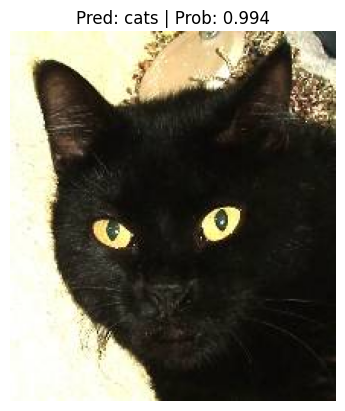

In [26]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple
import random
from pathlib import Path

def pred_and_plot_image(
   model: torch.nn.Module,
   class_names: List[str],
   image_path: str,
   image_size: Tuple[int, int] = (224, 224),
   transform: transforms = None,
   device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
           transforms.Resize(image_size),
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
       ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max().item():.3f}")
    plt.axis(False)

test_folder = Path("/kaggle/input/reduced/dogs-vs-cats/test")
all_files = list(test_folder.glob('*/*'))
random_image_path = random.choice(all_files)
print(f"Selected image path: {random_image_path}")
pred_and_plot_image(model=model, image_path=str(random_image_path), class_names=class_names)